# Project 3: Predicting Boston Housing Prices

In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. We train different models on this data and whichever is found a good fit could then be used to make certain predictions about a home — in particular, its monetary value.

The dataset is taken from [here](https://www.cs.toronto.edu/~delve/data/datasets.html)

The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts.

Following steps have been taken before preprocessing:

* 16 data points have an 'MEDV' value of 50.0. These data points contain missing or censored values and have been removed.
* 1 data point has an 'RM' value of 8.78. This data point can be considered an outlier and has been removed.
* The features 'RM', 'LSTAT', 'PTRATIO', and 'MEDV' are essential. The remaining non-relevant features have been excluded.
* The feature 'MEDV' has been multiplicatively scaled to account for 35 years of market inflation.

#### Loading Data and Importing libraries:-

In [2]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)

# Success
print('Boston housing dataset has {0} data points with {1} variables each'.format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each


In [16]:
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
###########################################

import matplotlib.pyplot as pl
import numpy as np
import sklearn.learning_curve as curves
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import ShuffleSplit, train_test_split

def ModelLearning(X, y, clf):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.2, random_state = 0)
    
    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([1,3,6,10]):
        # Create a Decision tree regressor at max_depth = depth
        regressor = clf(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = curves.learning_curve(regressor, X, y, cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')

        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])

    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    pl.show()

def ModelComplexity(X, y, clf):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = curves.validation_curve(clf(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')
    pl.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    pl.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    pl.fill_between(max_depth, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    pl.fill_between(max_depth, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')

    # Visual aesthetics
    pl.legend(loc = 'lower right')
    pl.xlabel('Maximum Depth')
    pl.ylabel('Score')
    pl.ylim([-0.05,1.05])
    pl.show()


def PredictTrials(X, y, fitter, data):
    """ Performs trials of fitting and predicting data. """

    # Store the predicted prices
    prices = []

    for k in range(10):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = k)

        # Fit the data
        reg = fitter(X_train, y_train)

        # Make a prediction
        pred = reg.predict([data[0]])[0]
        prices.append(pred)

        # Result
        print("Trial {}: ${:,.2f}".format(k+1, pred))
        
    # Display price range
    print("\nRange in prices: ${:,.2f}".format(max(prices) - min(prices)))

def plot_decision_regions(X, y, classifier, resolution=0.02):

    from matplotlib.colors import ListedColormap

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)

c:\program files\python36-32\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Data Exploration
we need to separate the dataset into **features** and the **target** variable. 

Features:-
* 'RM'
* 'LSTAT'
* 'PTRATIO'

Target variable:-
* 'MEDV'

### Implementation: Calculate Statistics

Implementation: Calculate Statistics

In the code cell below, we implement the following:

* Calculate the minimum, maximum, mean, median, and standard deviation of 'MEDV', which is stored in prices.
* Store each calculation in their respective variable.



In [5]:
# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Quartiles
first_quartile = np.percentile(prices, 25)
third_quartile = np.percentile(prices, 75)
inter_quartile = third_quartile - first_quartile

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:,.2f}".format(minimum_price))
print("Maximum price: ${:,.2f}".format(maximum_price))
print("Mean price: ${:,.2f}".format(mean_price))
print("Median price ${:,.2f}".format(median_price))
print("Standard deviation of prices: ${:,.2f}".format(std_price))
print("First quartile of prices: ${:,.2f}".format(first_quartile))
print("Second quartile of prices: ${:,.2f}".format(third_quartile))
print("Interquartile (IQR) of prices: ${:,.2f}".format(inter_quartile))

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13
First quartile of prices: $350,700.00
Second quartile of prices: $518,700.00
Interquartile (IQR) of prices: $168,000.00


# Question 1 - Feature Observation

As a reminder, we are using three features from the Boston housing dataset: 'RM', 'LSTAT', and 'PTRATIO'. For each data point (neighborhood):

* 'RM' is the average number of rooms among homes in the neighborhood.
* 'LSTAT' is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
* 'PTRATIO' is the ratio of students to teachers in primary and secondary schools in the neighborhood.

*Using your intuition, for each of the three features above, do you think that an increase in the value of that feature would lead to an increase in the value of 'MEDV' or a decrease in the value of 'MEDV'? Justify your answer for each. Hint: Would you expect a home that has an 'RM' value of 6 be worth more or less than a home that has an 'RM' value of 7?

**Answer:** Based on my intuition: 
**1)** Increasing the average number of rooms(RM) among homes in the neighborhood would increase the MDEV, since homes with more rooms have larger square footages which should raise the overal value of the home. 
**2)** Increasing the percentage of "lower class" homeowners in the neighborhood (LSTAT) should decrease the MDEV, as this could mean that a particular neighborhood is located at an area where lower income/class people live and these people are probably only able to afford lower cost homes. 
**3)** Increasing the ratio of students to teachers (PTRATIO) would lead to a decrease in MDEV. In general, better school have lower teacher to student ratios, as allows for more access/interaction between a given teacher and a smaller group of students. That being said, most families look for homes in located in neighborhoods with good schools for the benefit of their kids' education, which drives up the prices of the homes in those neighborhoods. Therefore, assuming that increasing the PTRATIO correlates to worse schools in the neighborhood, then the prices of the homes (MDEV) should decrease.


### Visualization

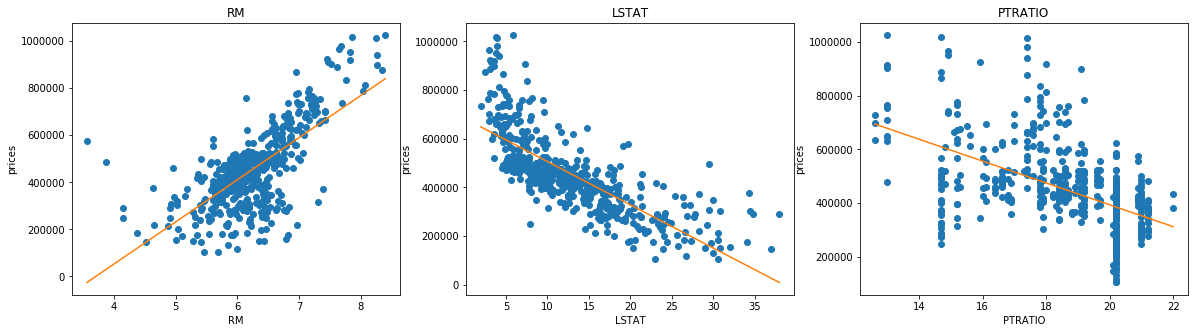

In [6]:
# Using pyplot
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))

# i: index
for i, col in enumerate(features.columns):
    # 3 plots here hence 1, 3
    plt.subplot(1, 3, i+1)
    x = data[col]
    y = prices
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')

Reference: Simple guide to [Enumerate](https://www.codecademy.com/en/forum_questions/5087f2d786a27b02000041a9)

## Model Development
In this section of the project,we will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, we will be calculating the "[coefficient of determination](https://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination)", R2, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions.

The values for R2 range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the target variable. A model with an R2 of 0 always fails to predict the target variable, whereas a model with an R2 of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the features. A model can be given a negative R2 as well, which indicates that the model is no better than one that naively predicts the mean of the target variable.

For the performance_metric function in the code cell below, you will need to implement the following:

* Use r2_score from sklearn.metrics to perform a performance calculation between y_true and y_predict.
* Assign the performance score to the score variable.

In [7]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """

    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)

    # Return the score
    return score

## Question 2 - Goodness of Fit

Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value  | Prediction |
| ------------- | ------------- |
| 3.0  | 2.5  |
| -0.5  | 0.0  |
| 2.0  | 2.1  |
| 7.0  | 7.8  |
| 4.2  | 5.3  |

*Would you consider this model to have successfully captured the variation of the target variable? Why or why not?

Run the code cell below to use the performance_metric function and calculate this model's coefficient of determination.

In [9]:

# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score)
     )

Model has a coefficient of determination, R^2, of 0.923.


Answer:

* R^2 = 92.3%
* This implies 92.3% of variation is explained by the target variable and it seems to be high.
* Potential pitfall: We only have five points here, and it may be hard to draw conclusion that is statistically significant.

### Implementation: Shuffle and Split Data
We split the Boston housing data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, we need to implement the following:

* Use train_test_split from sklearn.cross_validation to shuffle and split the features and prices data into training and testing sets.
    * Split the data into 80% training and 20% testing.
    * Set the random_state for train_test_split to a value of your choice. This ensures results are consistent.
* Assign the train and testing splits to X_train, X_test, y_train, and y_test.

In [10]:
# Import 'train_test_split'
from sklearn.cross_validation import train_test_split

# TODO: Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=10)

# Success
print ("Training and testing split was successful.")

Training and testing split was successful.


In [11]:
# Check if split is actually correct
# We can see it's roughly 80% train and 20% train
# So we can proceed!
print(features.shape[0])
print(float(X_train.shape[0]) / float(features.shape[0]))
print(float(X_test.shape[0]) / float(features.shape[0]))

489
0.7995910020449898
0.20040899795501022


## Question 3 - Training and Testing

What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?
Hint: What could go wrong with not having a way to test your model?

Answer:

* Motivation: we need a way to choose between machine learning models.
     * And our goal is to estimate likely performance of a model on out-of-sample data.
* Initial idea: we can train and test on the same data.
     * But, maximizing training accuracy rewards overly complex models that overfit the training data.
     * As you add more features, you can slowly reach a 100% accuracy but you are not able to generalize well.
* Alternative idea: we can use train/test split.
     * We can split the dataset into two pieces so that the model can be trained and tested on different data.
     * Then, testing accuracy is a better estimate than training accuracy of out-of-sample performance.

**This is an extension beyond the scope of the train/test split question, highlighting the issue of high variance simply using train/test split without k-fold cross-validation.**

* But we've a big problem with train/test split.
     * It provides a high variance estimate since changing which observations happen to be in the testing set can significantly change testing accuracy.
     * Testing accuracy can change a lot depending on a which observation happen to be in the testing set.
     * Hence we've to use k-fold cross-validation to solve this problem
     
     
## Analyzing Model Performance

In this third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, you'll investigate one particular algorithm with an increasing 'max_depth' parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.


### Learning Curves

The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R2, the coefficient of determination.

Run the code cell below and use these graphs to answer the following question.

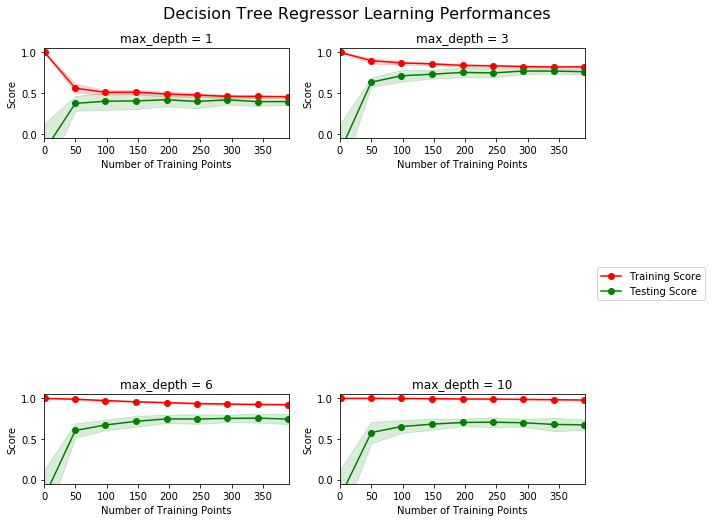

In [19]:
ModelLearning(features, prices, DecisionTreeRegressor)

From the figures above, we can see that the model has better perfomance while max depth = 3 where it got high scores both on training and testing and the more import point is these two scores are close.
Typically, the score of the training curve converge to some value as more training points are added and so as testing curve. However, the benefit of adding ‘more data’ has its limitation for fixing certain type of problems of models. As we can see scores all converge to certain value and no more decreasing happened as more data added as four pictures above.

## Question 4 - Learning the Data

*Choose one of the graphs above and state the maximum depth for the model. What happens to the score of the training curve as more training points are added? What about the testing curve? Would having more training points benefit the model?

Hint: Are the learning curves converging to particular scores?

* max_depth = 1 (High Bias Scenario)
     1.  We can see how the testing score (green line) increases with the number of observations.
           * However, the testing score only increases to approximately 0.4, a low score.
           * This indicates how the model does not generalize well for new, unseen, data.
     2.  Moreover, the training score (red line) decreases with the number of observations.
          *  Also, the training score decreases to a very low score of approximately 0.4.
          *  This indicates how the model does not seem to fit the data well.
     3.  Thus, we can say this model is facing a high bias problem. Consequently, having more training points would not benefit the model as the model is underfitting the dataset. Instead, one should increase the model complexity to better fit the dataset.
          *  Morever, the teting score has reached a plateau suggesting the model may not improve from adding more training points.

**This is an extension explaining the rest of the depths for completeness. I have summarized everything instead of writing in full sentences.**

*  max_depth = 3 (Ideal Scenario)
      1. Testing score (green line) increases with training points
          * Reaches ~0.8
          * High score
          * Generalize well
      2. Training score (red line) decreases slightly with training points
          * Reachers ~0.8
          * High score
          * Fit dataset well
      3. There seems to be no high bias or high variance problem
          * Model fits and generalizes well
          * Ideal
          * More training points should help it become an even more ideal model!
* max_depth = 10 (High Variance Scenario)
     1. Testing score (green line) increases with training points
          * Reaches ~0.7
          * Not so high score
          * Does not generalize well
     2. Training score (red line) barely decreases with training points
          * At ~1.0
          * Almost perfect score
          * Overfitting dataset
     3. There seems to be a high variance problem
          * Overfitting
* max_depth = 6 (Slightly High Variance Scenario)
     1. Testing score (green line) increases with training points
          * Reaches ~0.75
          * Not so high score
          *  Does not generalize well
     2. Training score (red line) decreases slightly with training points
           * At ~0.9
           * High score
           * Overfitting dataset
     3. There seems to be a high variance problem
           * Overfitting
           * More training points might help
           * This is getting close to the ideal scenario!


### Complexity Curves

The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the learning curves, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the performance_metric function.

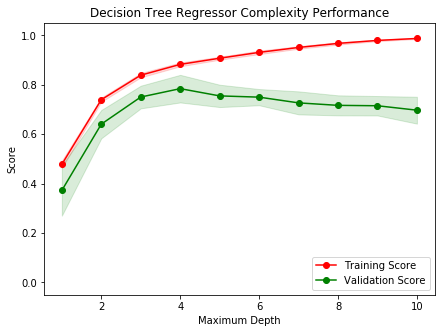

In [18]:
ModelComplexity(X_train, y_train, DecisionTreeRegressor)


## Question 5 - Bias-Variance Tradeoff

When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?

**Hint:** How do you know when a model is suffering from high bias or high variance?

**Answer:**
**Identifying when a model is suffering from high bias or high variance.**

   * It is easy to identify whether the model is suffering from a high bias or a high variance.
       * High variance models have a gap between the training and validation scores.
           * This is because it is able to fit the model well but unable to generalize well resulting in a high training score but low validation score.
       * High bias models have have a small or no gap between the training and validations scores.
           * This is because it is unable to fit the model well and unable to generalize well resulting in both scores converging to a similar low score.

**Maximum depth of 1: High Bias**

   * Both training and testing scores are low.
   * There is barely a gap between the training and testing scores.
   * This indicates the model is not fitting the dataset well and not generalizing well hence the model is suffering from high bias.

**Maximum depth of 10: High Variance**

   * Training score is high. Testing score is low
   * There is a substantial gap between the training and testing scores.
   * This indicates the model is fitting the dataset well but not generalizing well hence the model is suffering from high variance.

## Question 6 - Best-Guess Optimal Model

Which maximum depth do you think results in a model that best generalizes to unseen data? What intuition lead you to this answer?

**Answer:**

   * The maximum depth of 4.
   * The training score seems to plateau here, indicating the highest possible score for the model's ability to generalize to unseen data.
   * Gap between the training score and testing score does not seem to be substantial too, indicating that the model may not be suffering from a high variance scenario.
   
_____________________________________________________________________________________________________________________________

## Evaluating Model Performance

In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from fit_model.

## Question 7 - Grid Search

What is the grid search technique and how it can be applied to optimize a learning algorithm?

**Answer:**

   * In essence, the grid search technique allows one to define a grid of parameters that will be searched using K-fold cross-validation.
   * Importantly, the grid search technique exhaustively tries every combination of the provided hyper-parameter values in order to find the best model.
   * One can then find the highest cross-validation accuracy that matches with the corresponding parameters that optimizes the learning algorithm.

**Pro tip: RandomizedSearchCV**

   * Although we will be using GridSearchCV, it may be computationally expensive for a bigger dataset.
   * There are other techniques that could be used for hyperparameter optimization in order to save time like RandomizedSearchCV, in this case instead of exploring the whole parameter space just a fixed number of parameter settings is sampled from the specified distributions.
   * This proves useful when we need to save time but is not necessary in cases in cases like ours where the data set is relatively small.


## Question 8 - Cross-Validation

What is the k-fold cross-validation training technique? What benefit does this technique provide for grid search when optimizing a model?
Hint: Much like the reasoning behind having a testing set, what could go wrong with using grid search without a cross-validated set?

**Answer:**

   * K-fold cross-validation summary:
       * Dataset is split into K "folds" of equal size.
       * Each fold acts as the testing set 1 time, and acts as the training set K-1 times.
       * Average testing performance is used as the estimate of out-of-sample performance.
       * Also known as cross-validated performance.
   * Benefits of k-fold cross-validation:
       * More reliable estimate of out-of-sample performance than train/test split.
       * Reduce the variance of a single trial of a train/test split.
   * Hence, with the benefits of k-fold cross-validation, we're able to use the average testing accuracy as a benchmark to decide which is the most optimal set of parameters for the learning algorithm.
       * If we do not use a cross-validation set and we run grid-search, we would have different sets of optimal parameters due to the fact that without a cross-validation set, the estimate of out-of-sample performance would have a high variance.
       * In summary, without k-fold cross-validation the risk is higher that grid search will select hyper-parameter value combinations that perform very well on a specific train-test split but poorly otherwise.

* Limitation of k-fold cross-validation:

   * It does not work well when data is not uniformly distributed (e.g. sorted data).

## Implementation: Fitting a Model

Our final implementation requires that we bring everything together and train a model using the decision tree algorithm. To ensure that we are producing an optimized model, you will train the model using the grid search technique to optimize the 'max_depth' parameter for the decision tree. The 'max_depth' parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called supervised learning algorithms.

For the fit_model function in the code cell below, we will need to implement the following:

   * Use DecisionTreeRegressor from sklearn.tree to create a decision tree regressor object.
        * Assign this object to the 'regressor' variable.
   * Create a dictionary for 'max_depth' with the values from 1 to 10, and assign this to the 'params' variable.
   * Use make_scorer from sklearn.metrics to create a scoring function object.
       * Pass the performance_metric function as a parameter to the object.
       * Assign this scoring function to the 'scoring_fnc' variable.
   * Use GridSearchCV from sklearn.grid_search to create a grid search object.
       * Pass the variables 'regressor', 'params', 'scoring_fnc', and 'cv_sets' as parameters to the object.
       * Assign the GridSearchCV object to the 'grid' variable.

**Using GridSearchCV**


**Fitting a model**

In [29]:
# TODO: Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.grid_search import GridSearchCV
    from sklearn.metrics import make_scorer
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

    # TODO: Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':np.arange(1,11)}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search object
    grid = GridSearchCV(regressor, param_grid = params, scoring = scoring_fnc, cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_


## Making Predictions

Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a decision tree regressor, the model has learned what the best questions to ask about the input data are, and can respond with a prediction for the target variable. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

## Question 9 - Optimal Model

What maximum depth does the optimal model have? How does this result compare to your guess in Question 6?

Run the code block below to fit the decision tree regressor to the training data and produce an optimal model.


In [30]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)
print(reg)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))


DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
Parameter 'max_depth' is 4 for the optimal model.


So as we can see: 4!!

In [31]:
reg = fit_model(X_train, y_train)
reg.get_params()

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [32]:
# We can access our value from reg.get_params(), a dictionary, using dict['key']
reg.get_params()['max_depth']

4



**Answer:**

   * The optimal model has a maximum depth of 4.
   * The max depth is the same as my guess in question 6.



## Question 10 - Predicting Selling Prices

Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:


| Feature       | Client 1   | Client 2  | Client 3 |
| ------------- | ------------- | ---------- | ----------- |
| Total number of rooms in home     | 5 rooms | 5 rooms | 5 rooms |
| Neighborhood poverty level (as %) | 17      |   32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1     |    22-to-1 | 12-to-1 |

What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?
**Hint:** Use the statistics you calculated in the Data Exploration section to help justify your response.

Run the code block below to have your optimized model make predictions for each client's home.

In [34]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $406,933.33
Predicted selling price for Client 2's home: $232,200.00
Predicted selling price for Client 3's home: $938,053.85



**Answer:**

**Prices to recommend**

   * Client 1: 406,900
   * Client 2: 232,200
   * Client 3: 938,100

**Data Exploration Findings**

   * **Minimum price: $105000.00**
   * **Maximum price: $1,024,800.00**
   * **Mean price: $454,342.94**
   * **Median price $438,900.00**
   * **Standard deviation of prices: $165,340.28**

** Reasonableness**

  * The prices are rounded up to the nearest hundred as the prices in the dataset are all rounded to the nearest hundred.
  * Compared to the data-exploration, it seems that the houses' prices from client 1 and client 2 are below the mean and median prices.
       * For client 2, it seems reasonable due to the high poverty level and student-to-teacher ratio.
       * For client 1, it also seems reasonable due to the average poverty level and student-to-teacher ratio.
  *And the house's price from client 3 is way above the mean and median prices, nearing to the maximum price in the dataset.
       * This seems reasonable given the low poverty level and student-to-teacher ratio with a high number of rooms.


**Visualization**

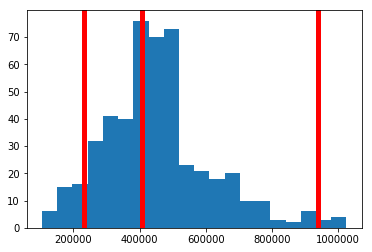

In [36]:
import matplotlib.pyplot as plt
plt.hist(prices, bins = 20)
for price in reg.predict(client_data):
    plt.axvline(price, lw = 5, c = 'r')



**Pro tip: Assess Reasonableness of Prediction using NearestNeighbors**

   * To assess if your prediction is reasonable, besides from comparing it with the median, the mean and checking if it is included in one standard deviation range, you could use SKlearn to find the nearest neighbours of the feature vector.
   * You can then contrast your results with the closest neighbours, the ones that have similar characteristics.



In [37]:
# Import NearestNeighbors
from sklearn.neighbors import NearestNeighbors

# Set number of neighbors
num_neighbors=5

def nearest_neighbor_price(x):
    # x is your vector and X is the data set.
    def find_nearest_neighbor_indexes(x, X):
        # Instantiate
        neigh = NearestNeighbors(num_neighbors)
        # Fit
        neigh.fit(X)
        distance, indexes = neigh.kneighbors(x)
        return indexes
        # This returns, the position, say for example [4, 55, 22]
        # array([[357, 397, 356, 141, 395]])
    indexes = find_nearest_neighbor_indexes(x, features)
    # Create list
    sum_prices = []
    # Loop through the array
    for i in indexes:
        # Append the prices to the list using the index position i
        sum_prices.append(prices[i])
    # Average prices
    neighbor_avg = np.mean(sum_prices)
    # Return average
    return neighbor_avg

# Test if it's working with a list [4, 55, 22]
arr_test = np.array([4, 55, 22]).reshape(1, -1)
print (nearest_neighbor_price(arr_test))

# client_data = [[5, 17, 15], # Client 1
               #[4, 32, 22], # Client 2
               #[8, 3, 12]]  # Client 3

# Loop through data, this is basically doing the following
# print(nearest_neighbor_price([5, 17, 15]))
# print(nearest_neighbor_price([4, 32, 22]))
# print(nearest_neighbor_price([8, 3, 12]]))
index = 0
for i in client_data:
    arr = np.array(i).reshape(1, -1)
    val=nearest_neighbor_price(arr)
    index += 1
    # num_neighbours is constant at 5
    # index changes from 1 to 2 to 3
    # value changes respectively from $372,540.00 to $162,120.00 to $897,120.00
    print("The predicted {} nearest neighbors price for home {} is: ${:,.2f}".format(num_neighbors,index, val))

280980.0
The predicted 5 nearest neighbors price for home 1 is: $372,540.00
The predicted 5 nearest neighbors price for home 2 is: $162,120.00
The predicted 5 nearest neighbors price for home 3 is: $897,120.00


In [39]:
print(features.describe())

               RM       LSTAT     PTRATIO
count  489.000000  489.000000  489.000000
mean     6.240288   12.939632   18.516564
std      0.643650    7.081990    2.111268
min      3.561000    1.980000   12.600000
25%      5.880000    7.370000   17.400000
50%      6.185000   11.690000   19.100000
75%      6.575000   17.120000   20.200000
max      8.398000   37.970000   22.000000


For these three given features in the model, all of them seem to be reasonable not only on intuition but also on empirical evidence.

For Client 1: The predicting selling price falls in μ±σ. Given lower LSTAT than the average of features.LSTAT and both RM and PTRATIO close to their averages repectively, we might predict that Client 1 should expect a price slightly lower that average. Also, we might find that somehow the LSTAT takes a important role in the model.

For Client 2: The predicting selling price falls in μ±2σ. All of three features are lower than the average, we might predict further lower price for Client 2.

For Client 3: The predicting selling price greater than μ+3σ. All of three features are better than 75%(25% for LSTAT and PTRATIO), so we might predict a highr price for Client 3.

_____________________________________________________________________________________

Statistics for Boston housing dataset:

* Minimum price: $105,000.00
* Maximum price: $1,024,800.00
* Mean price: $454,342.94 
* Median price $438,900.00

Standard deviation of prices: $165,340.28

* μ±σ: [$289,002.67, $619,683.22]
* μ±2σ: [$123,662.39, $785,023.50]
* μ±3σ: [$-41,677.89, $950,363.78]
* Range: $919,800.00  
* IQR: $168,000.00 

Outlier: > $774,900.00 or < $102,900.00

_______________________________________________________________________________________________


**Sensitivity**

An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. Run the code cell below to run the fit_model function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.


In [ ]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33

Trial 2: $419,700.00

Trial 3: $415,800.00

Trial 4: $420,622.22

Trial 5: $413,334.78

Trial 6: $411,931.58

Trial 7: $399,663.16

Trial 8: $407,232.00

Trial 9: $351,577.61

Trial 10: $413,700.00

**Range in prices:** $69,044.61



## Question 11 - Applicability

In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.
Hint: Some questions to answering:

   * How relevant today is data that was collected from 1978?
   * Are the features present in the data sufficient to describe a home?
   * Is the model robust enough to make consistent predictions?
   * Would data collected in an urban city like Boston be applicable in a rural city?

Answer:

   * Data collected from a rural city may not be applicable as the demographics would change and other features may be better able to fit the dataset instead of a model with features that was learned using urban data.
   * The learning algorithm learned from a very old dataset that may not be relevant because demographics have changed a lot since 1978.
   * There are only 3 features currently, there are more features that can be included such as crime rates, nearby to city, public transport access and more.

